# Logistic Regression with Word2vec

## Starting

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [20]:
#importing the training data
df=pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
#Summary of the dataset
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_urls(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['Text']=df['Text'].apply(denoise_text)

**Leaving the features with text data aside, we now find the correlation between other different features in the datset and their influence on score**

<ipython-input-23-eebffda4a03b>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)


<AxesSubplot:>

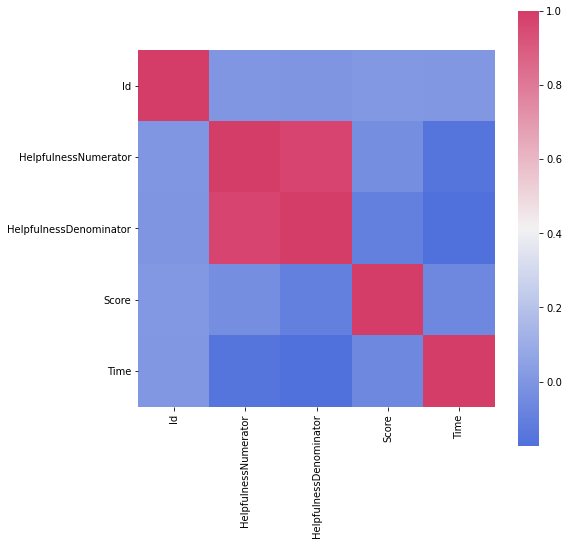

In [23]:
plt.figure(figsize = (8,8))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [24]:
del df['Id']
del df['Time']
del df['UserId']
del df['ProductId']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']

In [25]:
df.head()

,ProfileName,Score,Summary,Text
0,delmartian,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,dll pa,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"Natalia Corres ""Natalia Corres""",4,"""Delight"" says it all",This is a confection that has been around a fe...
3,Karl,2,Cough Medicine,If you are looking for the secret ingredient i...
4,"Michael D. Bigham ""M. Wassir""",5,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
df['Text'] = df['Text'] + ' ' + df['Summary'] + ' ' + df['ProfileName']
del df['Summary']
del df['ProfileName']
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [27]:
def score_sentiment(score):
    # Replace scores of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(score == 1 or score == 2 or score == 3):
        return 0
    else:
        return 1
df.Score = df.Score.apply(score_sentiment)    

In [28]:
df.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [29]:
df.isna().sum()

Score     0
Text     43
dtype: int64

In [30]:
df.Text.fillna("",inplace = True)

## Text Preprocessing

In [31]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [32]:
df["Text"] = df["Text"].str.lower()
df.head()

,Score,Text
0,1,i have bought several of the vitality canned d...
1,0,product arrived labeled as jumbo salted peanut...
2,1,this is a confection that has been around a fe...
3,0,if you are looking for the secret ingredient i...
4,1,great taffy at a great price. there was a wid...


In [33]:
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stop])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))
df.head()

,Score,Text
0,1,bought several vitality canned dog food produc...
1,0,product arrived labeled jumbo salted peanuts.....
2,1,"confection around centuries. light, pillowy ci..."
3,0,looking secret ingredient robitussin believe f...
4,1,great taffy great price. wide assortment yummy...


In [35]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["Text"] = df["Text"].apply(lambda text: lemmatize_words(text))
df.head()

,Score,Text
0,1,bought several vitality canned dog food produc...
1,0,product arrived labeled jumbo salted peanuts.....
2,1,"confection around centuries. light, pillowy ci..."
3,0,looking secret ingredient robitussin believe f...
4,1,great taffy great price. wide assortment yummy...


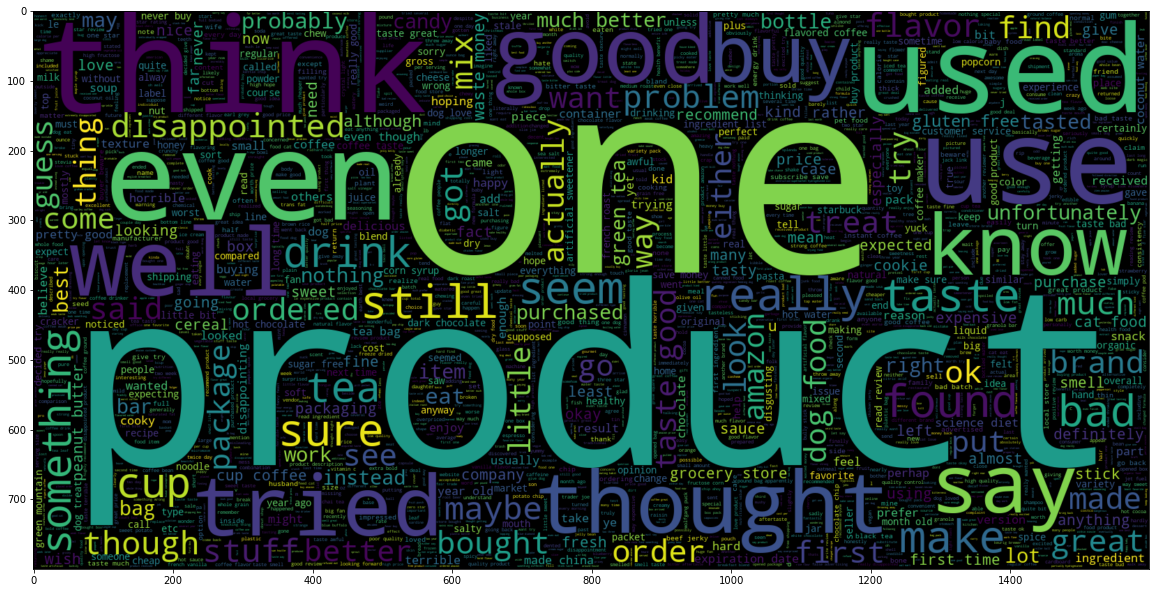

In [36]:
plt.figure(figsize = (20,20)) # Text with bad/average reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

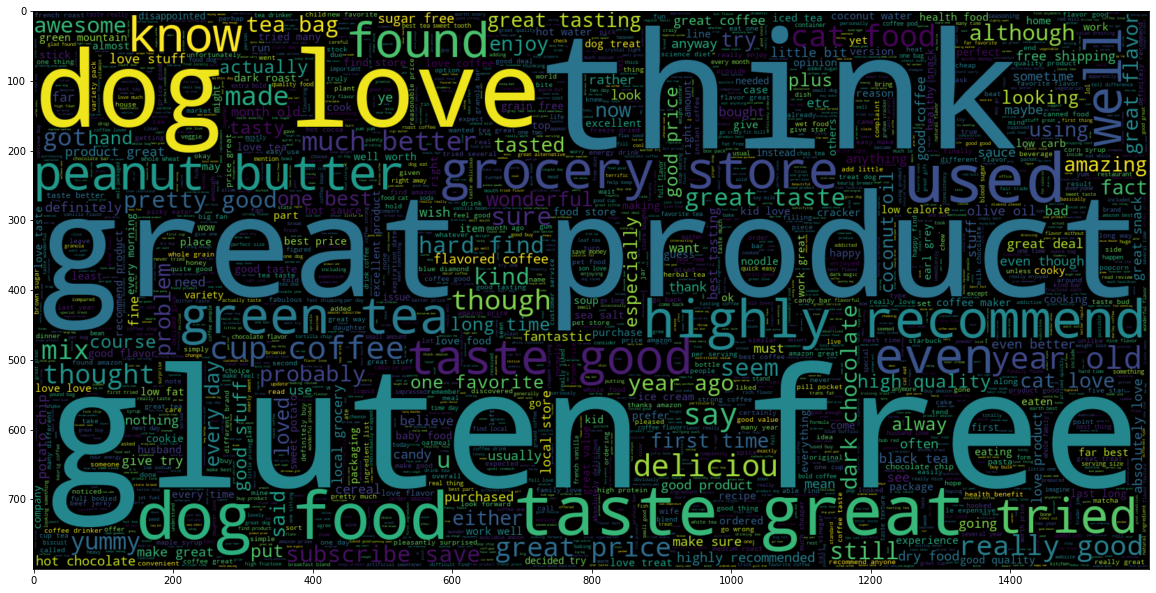

In [37]:
plt.figure(figsize = (20,20)) # Text with good reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score ==1].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [39]:
# run command python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner"])

# create train set by getting the document vector
docs_train = [nlp(doc).vector for doc in df.Text]
df_text = np.vstack(docs_train)
print('Shape of text set: {}'.format(df_text.shape))

df_scores = df.Score
print('Shape of scores set: {}'.format(df_scores.shape))

C:\Users\hp\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


NameError: name 'train' is not defined

In [42]:
df_text.shape

(568454, 300)

In [43]:
df_scores = df.Score
df_scores.head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [44]:
x_train,x_test,y_train,y_test = train_test_split(df_text,df_scores,random_state = 0)

In [48]:
lr=LogisticRegression(penalty='l2',max_iter=1000,C=1,random_state=0)

lr.fit(x_train,y_train)


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=1000, random_state=0)

In [52]:
lr_predict_train=lr.predict(x_train)

In [53]:
lr_score=accuracy_score(y_train,lr_predict_train)
print("lr_score :",lr_score)

lr_score : 0.8615916873856546


In [49]:
#Predicting the model for bag of words
lr_predict=lr.predict(x_test)

In [50]:
#Accuracy score for bag of words
lr_score=accuracy_score(y_test,lr_predict)
print("lr_bow_score :",lr_score)

lr_bow_score : 0.8614140760234741


In [51]:
#Classification report for bag of words
lr_report=classification_report(y_test,lr_predict,target_names=['0','1'])
print(lr_report)

              precision    recall  f1-score   support

           0       0.75      0.56      0.64     31133
           1       0.88      0.95      0.91    110981

    accuracy                           0.86    142114
   macro avg       0.82      0.75      0.78    142114
weighted avg       0.85      0.86      0.85    142114

